In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, train_test_split
from lightgbm import LGBMClassifier
import matplotlib.pyplot as pl
import gc
import shap

In [2]:
file_path = 'D:\\jupyter files\\shap_value_practice_data\\home-credit-default-risk\\'

In [3]:
def build_model_input():
    buro_bal = pd.read_csv(file_path + 'bureau_balance.csv')
    print('Buro bal shape : ', buro_bal.shape)
    
    print('transform to dummies')
    buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)
    
    print('Counting buros')
    buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])
    
    print('averaging buro bal')
    avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()
    
    avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
    del buro_bal
    gc.collect()
    
    print('Read Bureau')
    buro = pd.read_csv(file_path + 'bureau.csv')
    
    print('Go to dummies')
    buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
    buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
    buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')
    
    buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
    # buro_full.columns = ['buro_' + f_ for f_ in buro_full.columns]
    
    del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
    gc.collect()
    
    print('Merge with buro avg')
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
    
    print('Counting buro per SK_ID_CURR')
    nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])
    
    print('Averaging bureau')
    avg_buro = buro_full.groupby('SK_ID_CURR').mean()
    print(avg_buro.head())
    
    del buro, buro_full
    gc.collect()
    
    print('Read prev')
    prev = pd.read_csv(file_path + 'previous_application.csv')
    
    prev_cat_features = [
        f_ for f_ in prev.columns if prev[f_].dtype == 'object'
    ]
    
    print('Go to dummies')
    prev_dum = pd.DataFrame()
    for f_ in prev_cat_features:
        prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)
    
    prev = pd.concat([prev, prev_dum], axis=1)
    
    del prev_dum
    gc.collect()
    
    print('Counting number of Prevs')
    nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])
    
    print('Averaging prev')
    avg_prev = prev.groupby('SK_ID_CURR').mean()
    #print(avg_prev.head())
    del prev
    gc.collect()
    
    print('Reading POS_CASH')
    pos = pd.read_csv(file_path + 'POS_CASH_balance.csv')
    
    print('Go to dummies')
    pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)
    
    print('Compute nb of prevs per curr')
    nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    print('Go to averages')
    avg_pos = pos.groupby('SK_ID_CURR').mean()
    
    del pos, nb_prevs
    gc.collect()
    
    print('Reading CC balance')
    cc_bal = pd.read_csv(file_path + 'credit_card_balance.csv')
    
    print('Go to dummies')
    cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)
    
    nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    print('Compute average')
    avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
    avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
    
    del cc_bal, nb_prevs
    gc.collect()
    
    print('Reading Installments')
    inst = pd.read_csv(file_path + 'installments_payments.csv')
    nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
    inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
    
    avg_inst = inst.groupby('SK_ID_CURR').mean()
    avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]
    
    print('Read data and test')
    data = pd.read_csv(file_path + 'application_train.csv')
    test = pd.read_csv(file_path + 'application_test.csv')
    print('Shapes : ', data.shape, test.shape)
    
    y = data['TARGET']
    del data['TARGET']
    
    categorical_feats = [
        f for f in data.columns if data[f].dtype == 'object'
    ]
    categorical_feats
    for f_ in categorical_feats:
        data[f_], indexer = pd.factorize(data[f_])
        test[f_] = indexer.get_indexer(test[f_])
        
    data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    
    del avg_buro, avg_prev
    gc.collect()

    return data, test, y


In [4]:
import re
def get_name(name):
    cop = re.compile("[^\u4e00-\u9fa5^a-z^A-Z^0-9]") # 匹配不是中文、大小写、数字的其他字符
    new_name = cop.sub('', name) #将string1中匹配到的字符替换成空字符
    return new_name

In [5]:
data, test, y = build_model_input()

new_name_list = [get_name(name) for name in list(data.columns)]
data.columns = new_name_list

data_train, data_valid, y_train, y_valid = train_test_split(data, y, test_size=0.2, random_state=0)

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

In [6]:
data.columns

Index(['SKIDCURR', 'NAMECONTRACTTYPE', 'CODEGENDER', 'FLAGOWNCAR',
       'FLAGOWNREALTY', 'CNTCHILDREN', 'AMTINCOMETOTAL', 'AMTCREDITx',
       'AMTANNUITYx', 'AMTGOODSPRICEx',
       ...
       'ccbalccbalstatusRefused', 'ccbalccbalstatusSentproposal',
       'ccbalccbalstatusSigned', 'instSKIDPREV', 'instNUMINSTALMENTVERSION',
       'instNUMINSTALMENTNUMBER', 'instDAYSINSTALMENT', 'instDAYSENTRYPAYMENT',
       'instAMTINSTALMENT', 'instAMTPAYMENT'],
      dtype='object', length=380)

In [7]:
clf = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.03,
    num_leaves=30,
    colsample_bytree=.8,
    subsample=.9,
    max_depth=7,
    reg_alpha=.1,
    reg_lambda=.1,
    min_split_gain=.01,
    min_child_weight=2,
    silent=-1,
    verbose=-1,
)

clf.fit(
    data_train, y_train, 
    eval_set= [(data_train, y_train), (data_valid, y_valid)], 
    eval_metric='auc', verbose=100, early_stopping_rounds=30  #30
)

Training until validation scores don't improve for 30 rounds
[100]	training's auc: 0.779201	training's binary_logloss: 0.242767	valid_1's auc: 0.763555	valid_1's binary_logloss: 0.242803
[200]	training's auc: 0.800839	training's binary_logloss: 0.233891	valid_1's auc: 0.775869	valid_1's binary_logloss: 0.238003
[300]	training's auc: 0.814925	training's binary_logloss: 0.228279	valid_1's auc: 0.78042	valid_1's binary_logloss: 0.236285
[400]	training's auc: 0.826468	training's binary_logloss: 0.223792	valid_1's auc: 0.782228	valid_1's binary_logloss: 0.235568
Did not meet early stopping. Best iteration is:
[400]	training's auc: 0.826468	training's binary_logloss: 0.223792	valid_1's auc: 0.782228	valid_1's binary_logloss: 0.235568


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.03, max_depth=7,
        min_child_samples=20, min_child_weight=2, min_split_gain=0.01,
        n_estimators=400, n_jobs=-1, num_leaves=30, objective=None,
        random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=-1,
        subsample=0.9, subsample_for_bin=200000, subsample_freq=0,
        verbose=-1)

# Explain the model

In [9]:
# explain 10000 examples from the validation set
# each row is an explanation for a sample, and the last column in the base rate of the model
# the sum of each row is the margin (log odds) output of the model for that sample
shap_values = shap.TreeExplainer(clf.booster_).shap_values(data_valid.iloc[:10000,:])
print('length of shape: ', len(shap_values))
print('y: ', set(y))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


length of shape:  2
y:  {0, 1}


## Summarize the feature imporances with a bar chart

In [10]:
# 特征的整体影响。对于每一个样本，不同特征对于模型影响的绝对平均值

In [36]:
# compute the global importance of each feature as the mean absolute value
# of the feature's importance over all the samples
global_importances = np.abs(shap_values).mean(0)[:-1]

In [38]:
global_importances

array([[3.70270513e-04, 1.11664905e-02, 8.02847521e-02, ...,
        3.11673525e-03, 1.92387261e-03, 3.95504321e-02],
       [3.38818783e-04, 1.73549029e-02, 1.70608421e-01, ...,
        9.61602884e-04, 3.20387773e-03, 7.76451402e-02],
       [6.00685043e-04, 2.13988061e-01, 1.11142791e-01, ...,
        1.43808390e-02, 2.82810665e-03, 6.64158636e-03],
       ...,
       [2.34631684e-04, 1.06669623e-02, 2.42689718e-01, ...,
        3.34426851e-03, 6.75652200e-04, 4.48376155e-02],
       [7.58788691e-04, 9.22195270e-02, 5.70158483e-02, ...,
        1.05911300e-02, 1.09188272e-02, 5.77955976e-03],
       [6.54479612e-04, 9.04468726e-02, 7.60136842e-02, ...,
        4.86721485e-03, 8.20539474e-04, 9.53252329e-02]])

## Summarize the feature importances with a density scatter plot

In [32]:
# 密度散点图画出了所有样本的情况。
# 特征的排序是按照shap 的平均绝对值，对模型来说的最重要特征。
# 宽的地方表示有大量的样本聚集。
# 右边的颜色表示特征的值的大小，红色表示特征值高，蓝色表示特征值低。

# 比如，对于EXTSOURCE2 来说，EXTSOURCE2 的值越高，那么就会更可能令模型输出值越小（shap value 为负）
# 同理，如果EXTSOURCE2 的值越低，那么就会更可能令模型输出值越大（shap value 为正
# 图中EXTSOURCE2 的样本大量在shap value 为负的区域聚集。

# 需要注意的是，一些特征，比如SKDPDDEF 对于大多数人并不是重要特征
# 但是可能对于某一小部分人群非常重要
# 我们的图只是代表全局的情况，并能不是每个人的情况

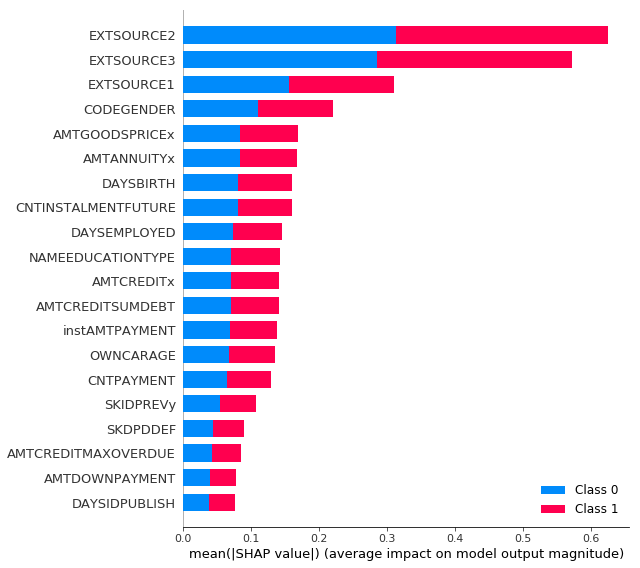

In [33]:
shap.summary_plot(shap_values, data_valid.iloc[:10000,:])

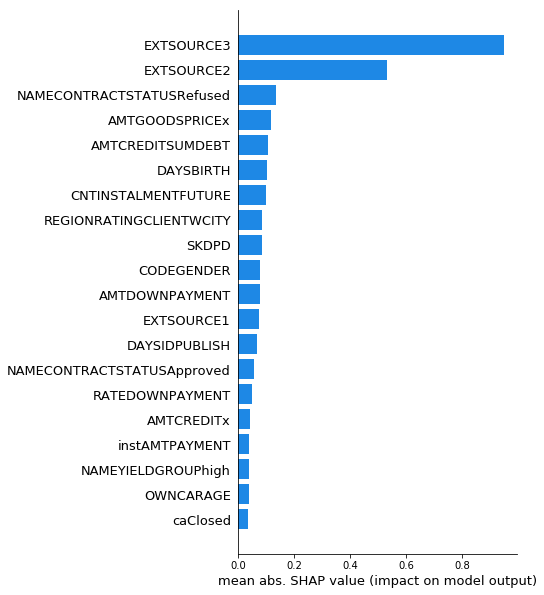

In [39]:
# make a bar chart that shows the global importance of the top 20 features
inds = np.argsort(-global_importances[0])
f = pl.figure(figsize=(5,10))
y_pos = np.arange(20)
inds2 = np.flip(inds[:20], 0)
pl.barh(y_pos, global_importances[0][inds2], align='center', color="#1E88E5")
pl.yticks(y_pos, fontsize=13)
pl.gca().set_yticklabels(data.columns[inds2])
pl.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('none')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)

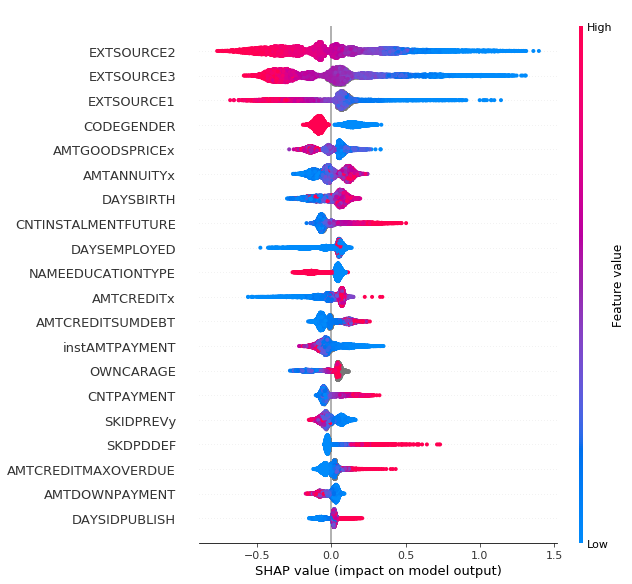

In [19]:
shap.summary_plot(shap_values[1], data_valid.iloc[:10000,:])

## Investigate the dependence of the model on each feature

In [14]:
# 这个图显示了更加清楚的特征对于模型输出的影响。
# x 轴表示特征的取值，y 值表示特征的shap value 值，也就是特征的取值，对于模型的输出会带来的变化量

# 其中我们可以发现对于同一个x 值，也就是特征取值相同的样本，它们的shap value不同。
# 其原因是，该特征和其他特征有着交互相应
# dependence_plot 可以自动选择另外一种特征，来表现这种交互效应
# 使用interaction_index = "auto", None, or int，可以选择某一个具体特征来着色

# 比如，对于 EXTSOURCE2 相同的样本，CODEGENDER 越大（红色），比越小（蓝色）
# 带来的对模型输出的变化更大（shap value 更大）

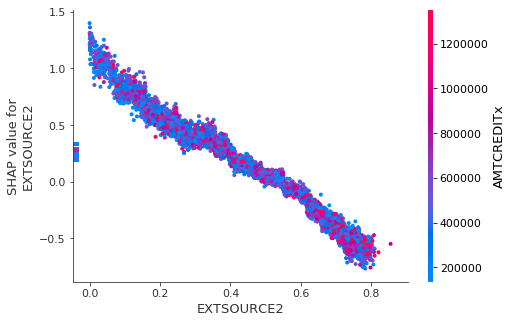

In [29]:
shap.dependence_plot("EXTSOURCE2", shap_values[1], data_valid.iloc[:10000,:], interaction_index = 7)

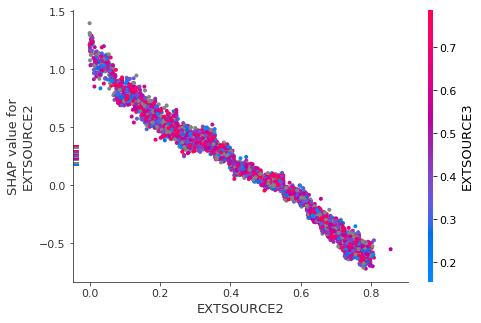

In [27]:
shap.dependence_plot("EXTSOURCE2", shap_values[1], data_valid.iloc[:10000,:])

In [16]:
# show=False，pl.xlim(0,5) 
# 使用这个的原因是，由于部分样本偏离整体数据过大，全部显示很难看出数据分布情况，
# 因此只显示0- 5 范围的数据

invalid value encountered in less


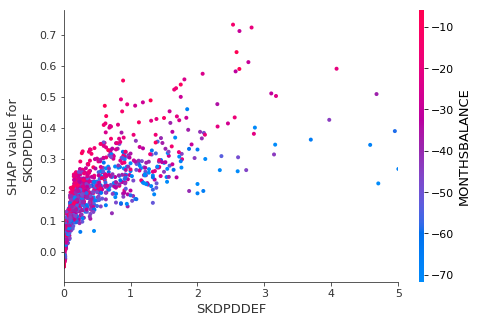

In [22]:
shap.dependence_plot("SKDPDDEF", shap_values[1], data_valid.iloc[:10000,:], show=False)
pl.xlim(0,5)
pl.show()

## Plot the SHAP dependence plots for the top 20 features

In [23]:
for i in reversed(inds2):
    shap.dependence_plot(i, shap_values[1], data_valid.iloc[:10000,:])

NameError: name 'inds2' is not defined